### Parse data

In [190]:
# Read files from results/ folder. The files have the filename: $program_$thread_$size
# The program is the name of the program that was run, the thread is the number of threads that were used, and the size is the size of the input. The files contains multiple lines with the time took to run the program in milliseconds. The program is one of the following: MPI_Block, MPI_Broadcast, MPI_Scatter, OpenMP, Sequential. Store the results in a dictionary with the following structure: {program: {thread: {size: time}}}. The time should be the arithmetic mean of the times for the same program, thread and size.

import os
import numpy as np
import pprint
import re

results = {}

for filename in os.listdir('results'):
    program, thread, size = filename[:-4].split('_')
    thread = int(thread)
    size = int(size)
    if program not in results:
      results[program] = {}
    if thread not in results[program]:
      results[program][thread] = {}
    with open(f'results/{filename}') as f:
      pattern = re.compile(r'(?:threads: \d+, )?transpose_time: (\d+\.\d+)')
      times = [float(match.group(1)) for match in pattern.finditer(f.read())]
      results[program][thread][size] = float(np.mean([float(time) for time in times]))

pprint.pprint(results)

{'MPI-Blocks': {1: {8: 5.452e-05,
                    64: 8.005999999999999e-05,
                    128: 0.00015596,
                    256: 0.0006621200000000001,
                    512: 0.003729645454545455,
                    1024: 0.020933700000000003,
                    2048: 0.1001957,
                    4096: 0.4269371500000001},
                2: {11: 0.00023340999999999998,
                    512: 0.0050878,
                    4096: 0.9573518999999999},
                4: {16: 0.0004272999999999999,
                    512: 0.0025232,
                    4096: 0.22503900000000004},
                8: {22: 0.00042742999999999996,
                    512: 0.0043325,
                    4096: 0.3221192857142857},
                16: {32: 0.00063578, 512: 0.0042658, 4096: 0.20365219999999998},
                32: {45: 0.0007111000000000001, 512: 0.0040155, 4096: 0.116694},
                64: {64: 0.0010551,
                     512: 0.010071600000000002,
                

### Generate bandwidth plots

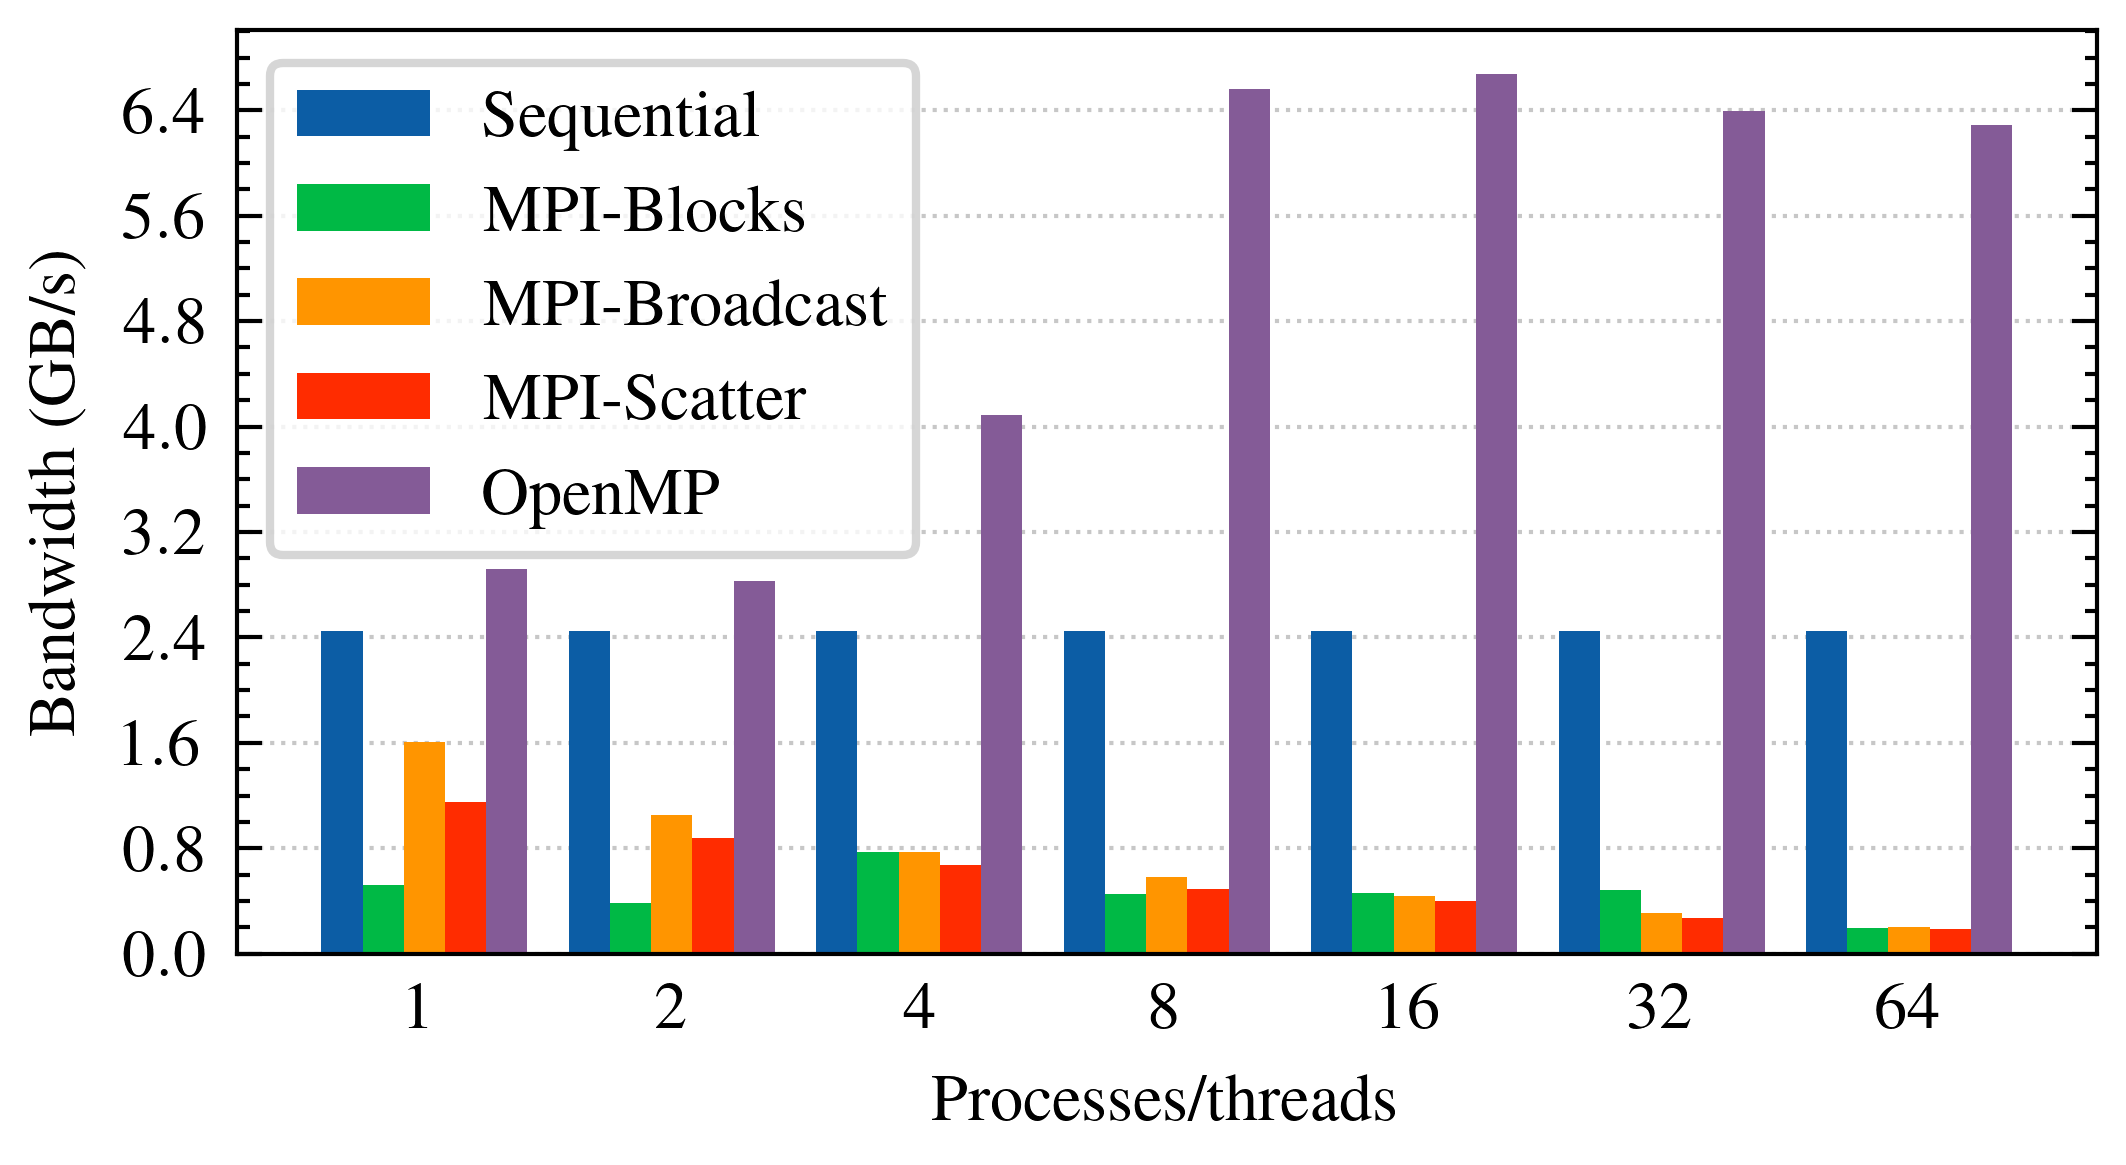

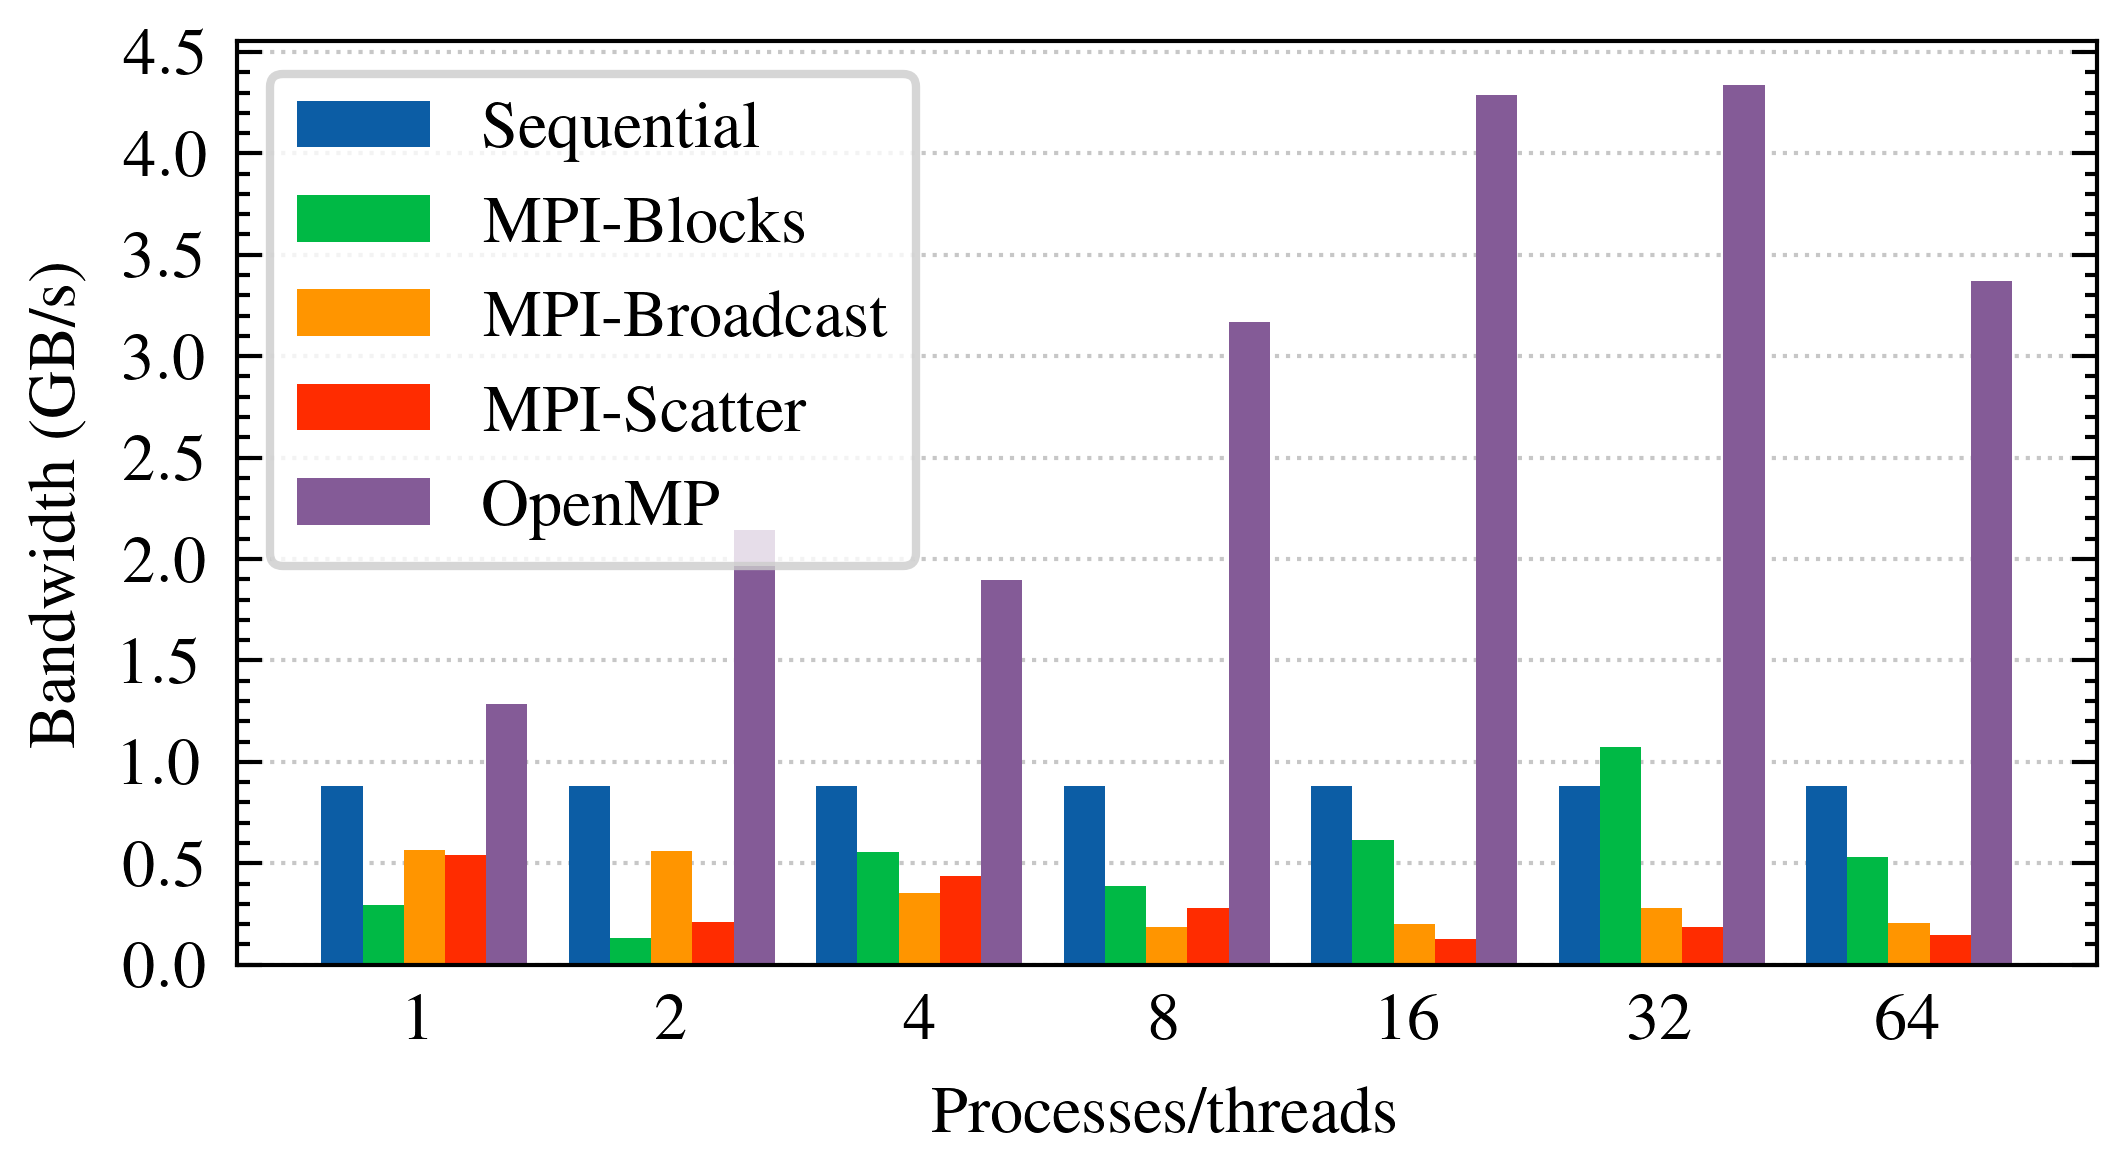

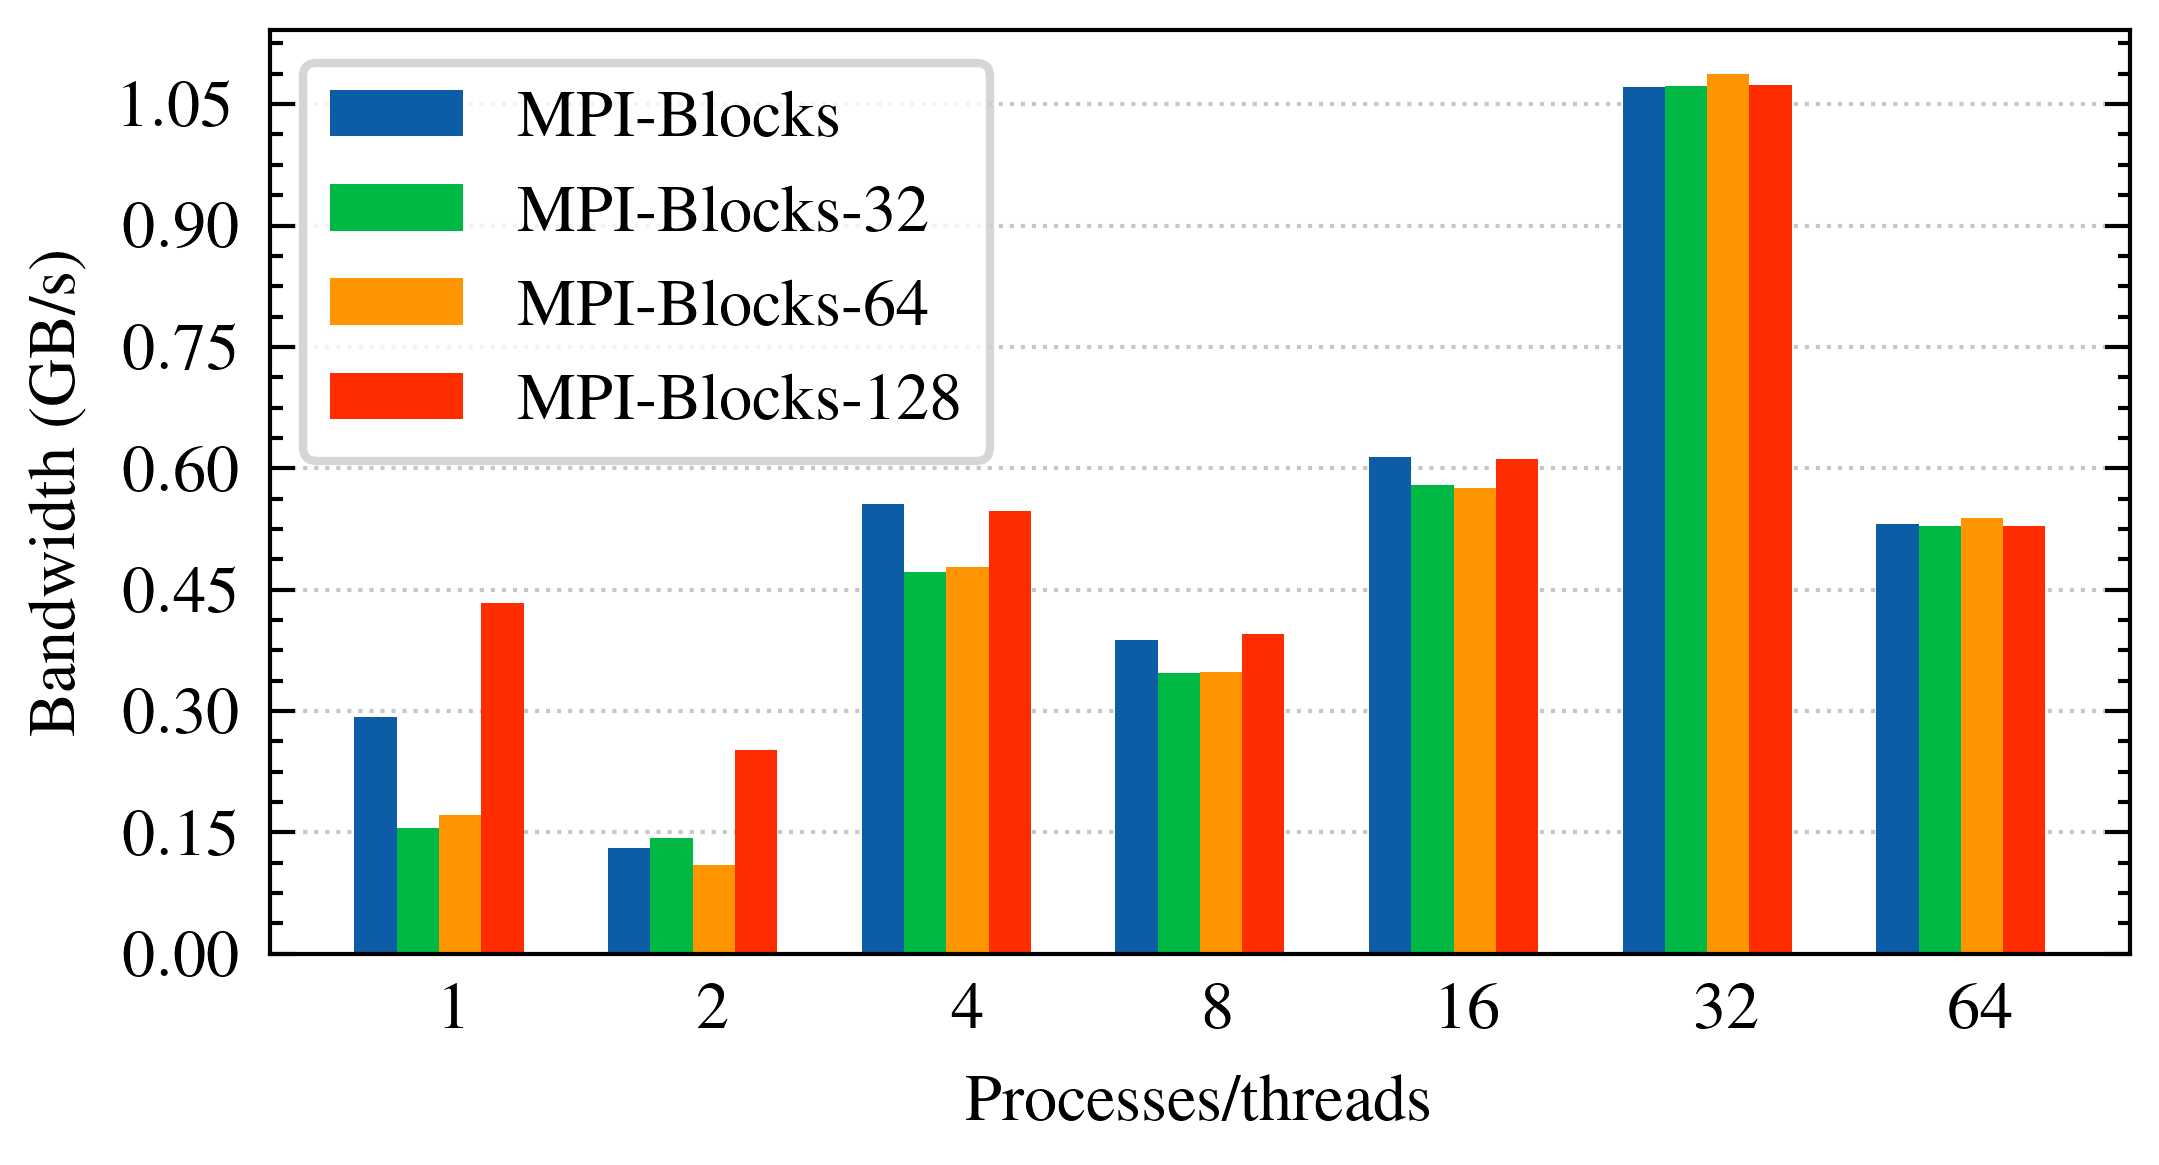

In [195]:
bandwidths = {}

threads = (1, 2, 4, 8, 16, 32, 64)

for size in (512, 4096):
  for program in ['Sequential', 'MPI-Blocks', 'MPI-Broadcast', 'MPI-Scatter', 'OpenMP']:
    if program == 'Sequential':
      bandwidths[program] = {}
      for thread in threads:
        bandwidths[program][thread] = size*size*2*4 / results[program][1][size] / 2**30
    else:
      bandwidths[program] = {}
      for thread in threads:
        bandwidths[program][thread] = size*size*2*4 / results[program][thread][size] / 2**30

    # sort the dictionary by size
    bandwidths[program] = dict(sorted(bandwidths[program].items()))
    # convert threads to string
    bandwidths[program] = {str(size): bandwidth for size, bandwidth in bandwidths[program].items()}

  import matplotlib.pyplot as plt
  import scienceplots

  plt.style.use(['science','ieee', 'std-colors'])


  fig, ax = plt.subplots(figsize=(4, 2))
  ax.yaxis.grid(True, linestyle=':', alpha=0.7)
  ax.yaxis.set_major_locator(plt.MaxNLocator(10))
  ax.tick_params(axis='x', which='both', bottom=False, top=False)
  ax.set_axisbelow(True)
  BAR_WIDTH = 0.2
  for i, program in enumerate(bandwidths):
    x = np.arange(len(bandwidths[program].keys()))
    bar = ax.bar(np.arange(len(bandwidths[program].keys())) * (1 + BAR_WIDTH) + i * BAR_WIDTH, bandwidths[program].values(), BAR_WIDTH, label=program)
    if program == 'sequential':
      for i, rect in enumerate(bar):
        rect.set_hatch('///')

  ax.set_xticks(np.arange(len(bandwidths[program])) * (1+BAR_WIDTH) + BAR_WIDTH + 0.2)
  ax.set_xticklabels(bandwidths[program].keys())
  ax.set_xlabel('Processes/threads')
  ax.set_ylabel('Bandwidth (GB/s)')
  ax.legend(frameon=True, fancybox=True, framealpha=0.8)
  plt.show()

  fig.savefig(f'bandwidth_{size}.pdf', bbox_inches='tight')


bandwidths = {}
for program in ['MPI-Blocks', 'MPI-Blocks-32', 'MPI-Blocks-64', 'MPI-Blocks-128']:
  if program == 'Sequential':
    bandwidths[program] = {}
    for thread in threads:
      bandwidths[program][thread] = size*size*2*4 / results[program][1][size] / 2**30
  else:
    bandwidths[program] = {}
    for thread in threads:
      bandwidths[program][thread] = size*size*2*4 / results[program][thread][size] / 2**30

  # sort the dictionary by size
  bandwidths[program] = dict(sorted(bandwidths[program].items()))
  # convert threads to string
  bandwidths[program] = {str(size): bandwidth for size, bandwidth in bandwidths[program].items()}


fig, ax = plt.subplots(figsize=(4, 2))
ax.yaxis.grid(True, linestyle=':', alpha=0.7)
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.set_axisbelow(True)
BAR_WIDTH = 0.2
for i, program in enumerate(bandwidths):
  x = np.arange(len(bandwidths[program].keys()))
  bar = ax.bar(np.arange(len(bandwidths[program].keys())) * (1 + BAR_WIDTH) + i * BAR_WIDTH, bandwidths[program].values(), BAR_WIDTH, label=program)
  if program == 'sequential':
    for i, rect in enumerate(bar):
      rect.set_hatch('///')

ax.set_xticks(np.arange(len(bandwidths[program])) * (1+BAR_WIDTH) + BAR_WIDTH + 0.2)
ax.set_xticklabels(bandwidths[program].keys())
ax.set_xlabel('Processes/threads')
ax.set_ylabel('Bandwidth (GB/s)')
ax.legend(frameon=True, fancybox=True, framealpha=0.8)
plt.show()

fig.savefig(f'bandwidth_blocks_{size}.pdf', bbox_inches='tight')

### Generate speedup plots

/var/folders/hc/3xgfw1711fv09jp475z0x05r0000gn/T/ipykernel_10135/500943220.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick}x' for tick in ax.get_yticks()])


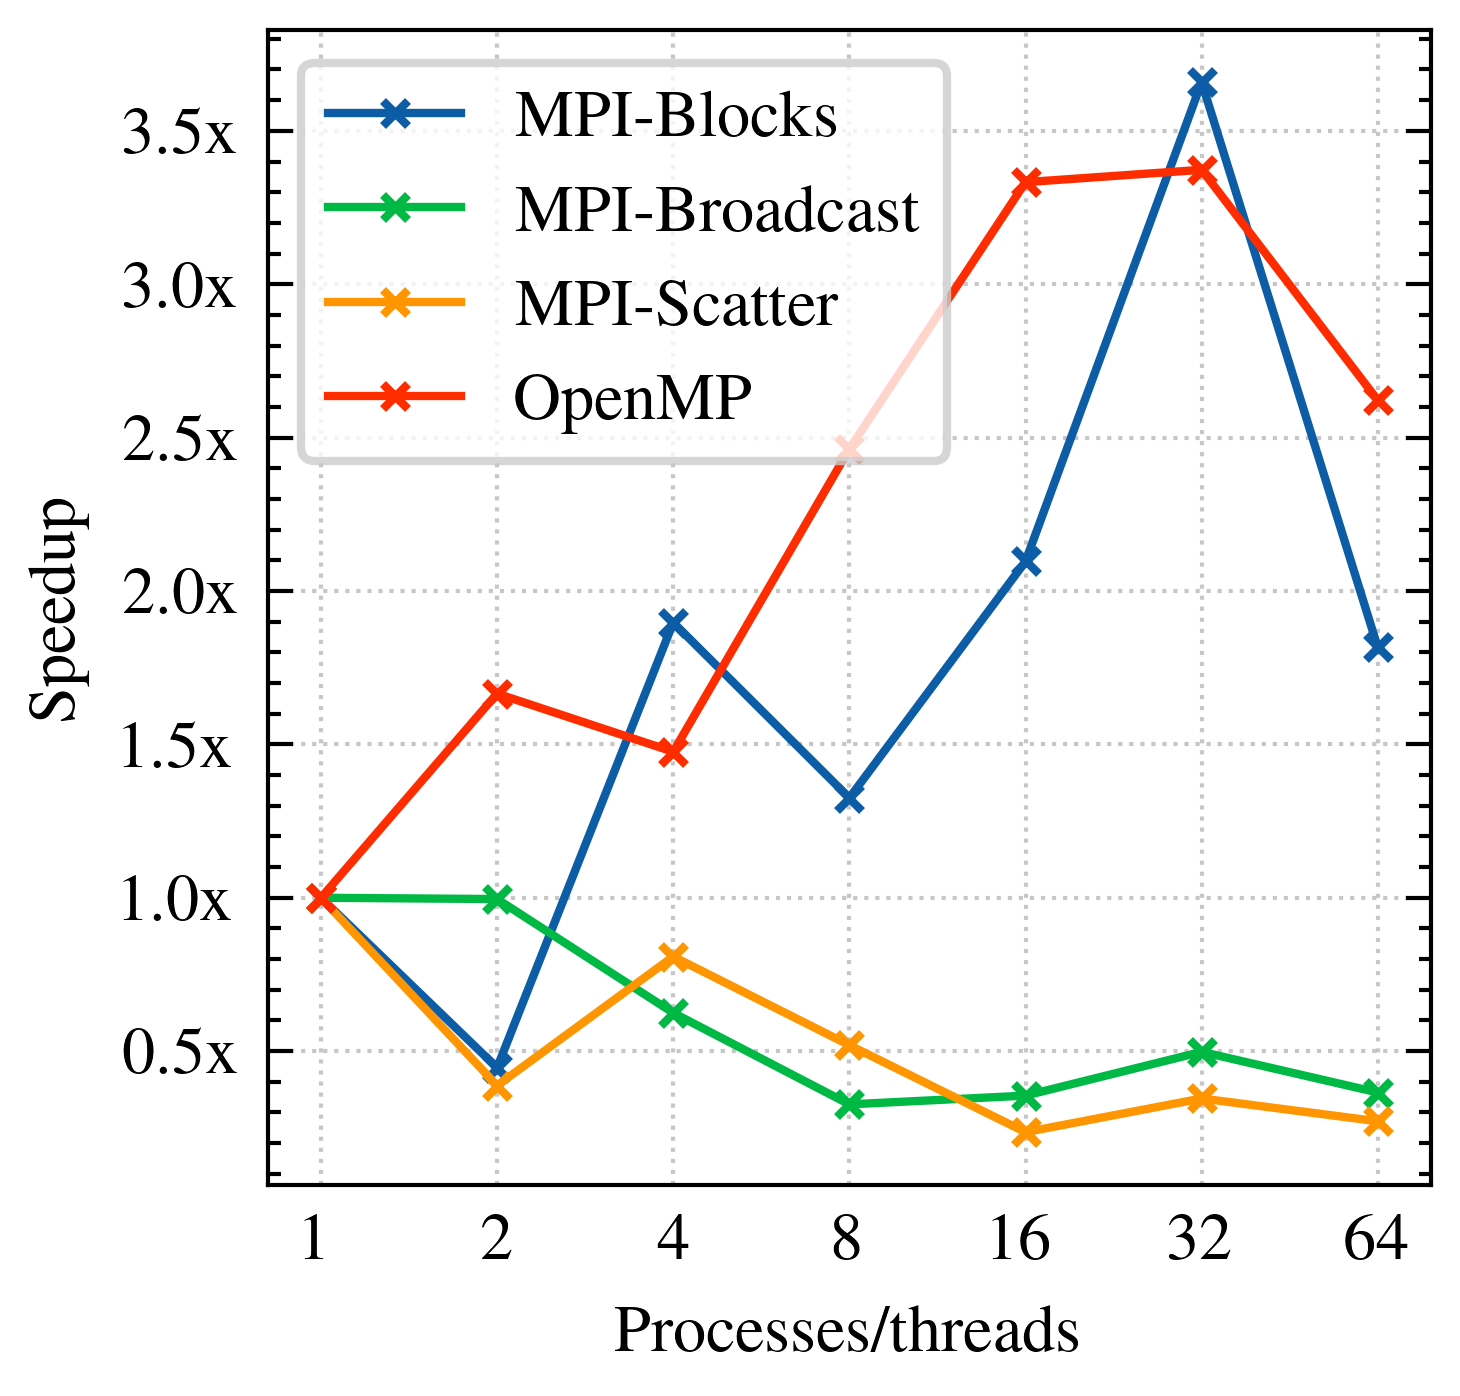

In [203]:
# Compute speedup with respect to version with one thread for 'MPI-Blocks', 'MPI-Broadcast', 'MPI-Scatter', 'openmp'. Store the results in a dictionary with the following structure: {program: {thread: speedup}}

speedups = {}

for program in ['MPI-Blocks', 'MPI-Broadcast', 'MPI-Scatter', 'OpenMP']:
  speedups[program] = {}
  for thread in threads:
    speedups[program][thread] = results[program][1][size] / results[program][thread][size]

# Plot the speedup for 'MPI-Blocks', 'MPI-Broadcast', 'MPI-Scatter', 'openmp' with respect to the number of threads. Use a logarithmic scale for the y-axis.

fig, ax = plt.subplots(figsize=(2.5, 2.5))
for program in speedups:
  ax.plot(threads, speedups[program].values(), label=program, marker='x', markersize=3)
  
ax.set_xscale('log')
ax.set_xticks(threads)
ax.set_yticklabels([f'{tick}x' for tick in ax.get_yticks()])
ax.set_xticklabels(threads)
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.grid(True, linestyle=':', alpha=0.7)
ax.set_xlabel('Processes/threads')
ax.set_ylabel('Speedup')
ax.legend(frameon=True, fancybox=True, framealpha=0.8)
plt.show()

fig.savefig(f'speedup.pdf', bbox_inches='tight')

### Generate scalability plots

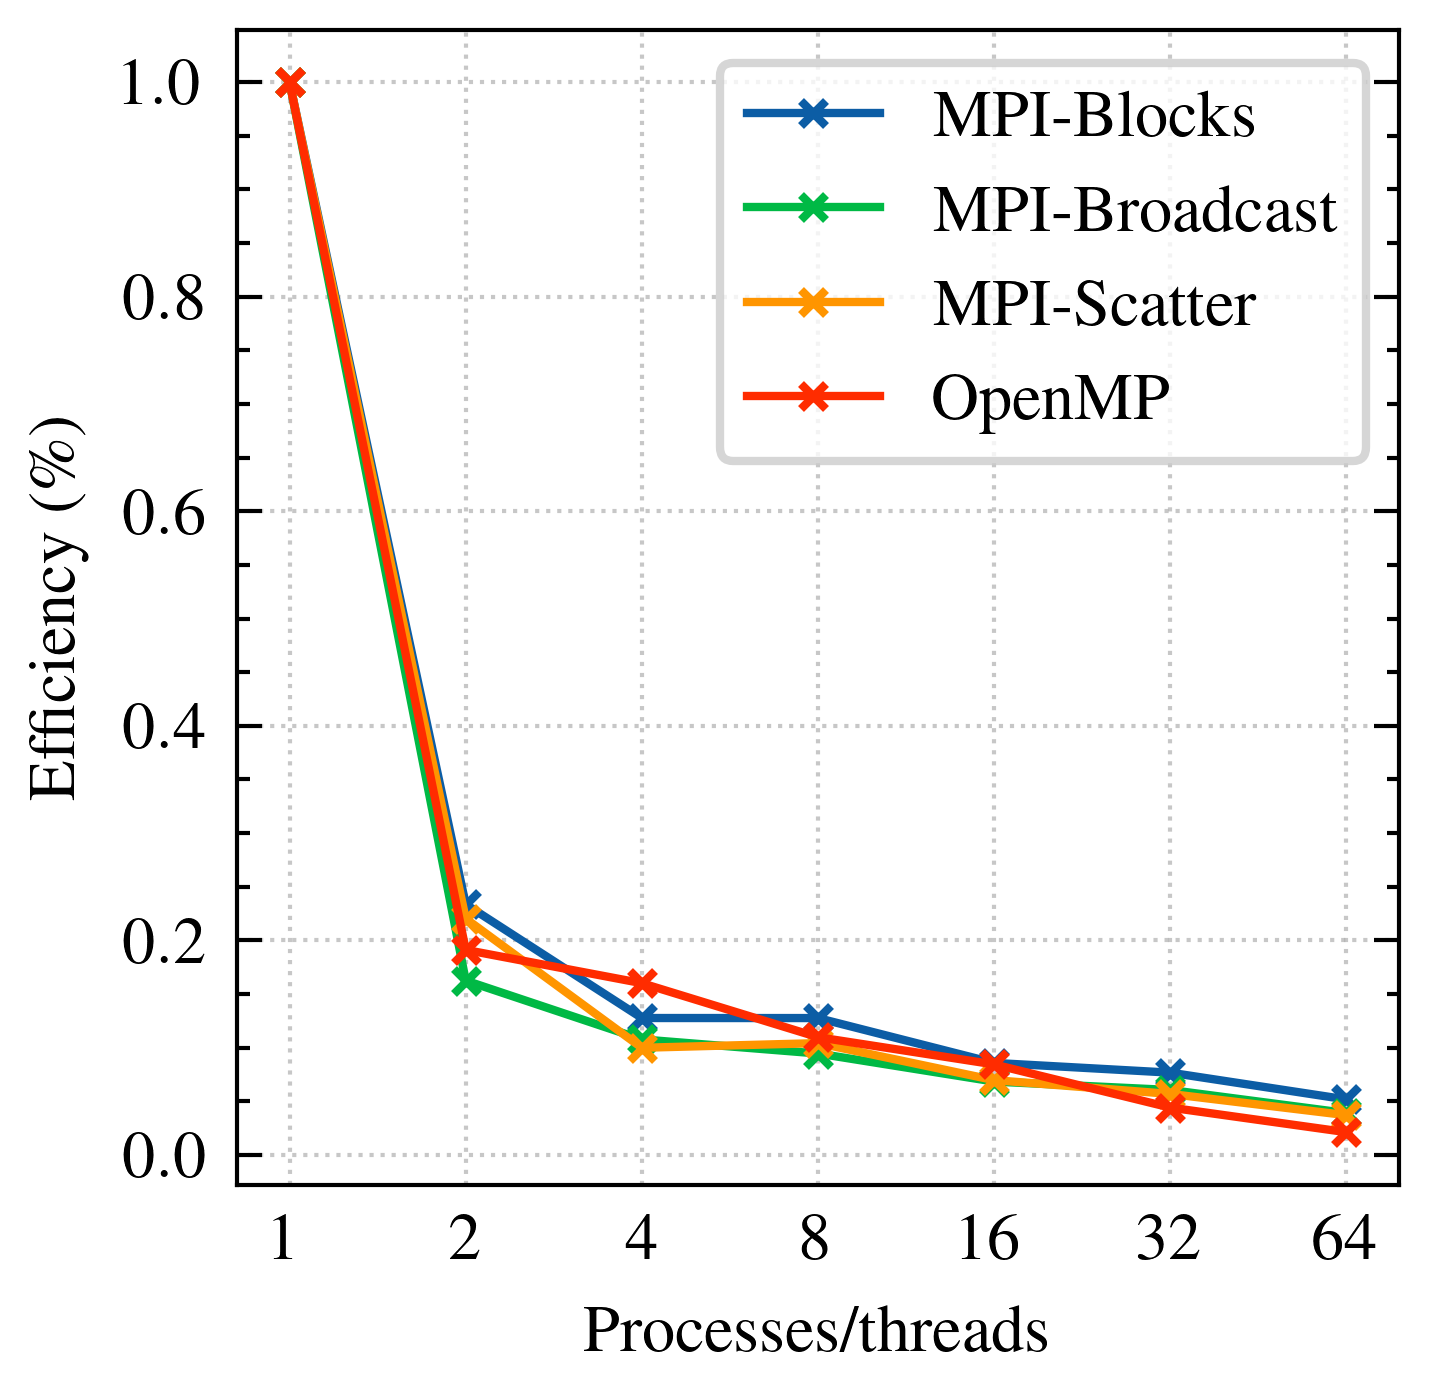

In [204]:
# Compute scalability for 'MPI-Blocks', 'MPI-Broadcast', 'MPI-Scatter', 'openmp'. Store the results in a dictionary with the following structure: {program: {thread: scalability}}

scalability = {}
sizes = {1: 8, 2: 11, 4: 16, 8: 22, 16: 32, 32: 45, 64: 64}

for program in ['MPI-Blocks', 'MPI-Broadcast', 'MPI-Scatter', 'OpenMP']:
  scalability[program] = {}
  for thread in threads:
    scalability[program][thread] = results[program][1][sizes[1]] / results[program][thread][sizes[thread]]

fig, ax = plt.subplots(figsize=(2.5, 2.5))
for program in scalability:
  ax.plot(threads, scalability[program].values(), label=program, marker='x', markersize=3)
  
ax.set_xscale('log')
ax.set_xticks(threads)
ax.set_xticklabels(threads)
ax.tick_params(axis='x', which='both', bottom=False, top=False)
ax.grid(True, linestyle=':', alpha=0.7)
ax.set_xlabel('Processes/threads')
ax.set_ylabel('Efficiency (\\%)')
ax.legend(frameon=True, fancybox=True, framealpha=0.8)
plt.show()

fig.savefig('efficiency.pdf', bbox_inches='tight')